##**Word Embedding:**

Word Embedding es el proceso a través del cual se toma una plabra y se le crea una representación vectorial en un espacio N-dimensional. Como ejemplo simple, podría imaginar que cada palabra tiene una representación tridimensional y luego trazar las palabras en un espacio 3D usando estos números como coordenadas. El objetivo aquí es crear un algoritmo para producir las coordenadas de cada palabra (llamadas embeddings), de modo que palabras similares estén geográficamente cerca en el espacio vectorial y palabras diferentes estén distantes en el espacio vectorial. Las incrustaciones de palabras salvan la barrera entre el lenguaje natural y el lenguaje de máquina, por lo que es difícil subestimar la necesidad de representaciones vectoriales de alta calidad.

##**Word2Vec:**

Word2Vec es una familia de algoritmos propuestos por Google, los cuales permiten hallar una representación vectorial N-dimensional **estática (Es decir, que no tiene en cuenta el contexto que la rodea),** para cada palabra del vocabulario. A esto le podemos llamar codificación **Semántica denotacional** de las palabras.

Más adelante veremos, como a diferencia de los modelos Word2Vec, los **Large Pre-Trained Languaje Models (LLMs)** permiten hallar representaciones vectoriales N-dimensionales **dinámicas (Es decir, que se tiene en cuenta el contexto que la rodea),** para cada palabra del vocabulario. A esto lo podemos llamar codificación **semántica distribucional** de las palabras.

##**Introducción a Word Embedding:**

Antes de 2013 (antes de los modelos Word2Vec), las incrustaciones de palabras se creaban a menudo mediante codificación one-hot. Este método para producir representaciones vectoriales es muy simple: para cada palabra construya un vector con 0s en cada elemento, excepto en la posición igual al ID del token (que es asignado en orden alfabético) que debe completarse con 1. Esto crea un vector único para cada palabra, donde la posición de 1 indica qué palabra se está codificando (de ahí el nombre "one-hot").

Por ejemplo, considere un modelo que produce vectores para codificar las siguientes cinco palabras: cat, kitten, dog, puppy y mouse. La colección de palabras que un modelo puede codificar se denomina vocabulario , y el número de palabras del vocabulario se denomina tamaño del vocabulario . Como se muestra a continuación, el tamaño del vocabulario dicta las dimensiones de los vectores que producirá un modelo one-hot:

- $cat:[1,0,0,0,0]$
- $dog:[0,1,0,0,0]$
- $kitten:[0,0,1,0,0]$
- $mouse:[0,0,0,1,0]$
- $puppy:[0,0,0,0,1]$

El vocabulario suele estar ordenado alfabéticamente, por lo que el orden de las codificaciones seguirá estas palabras alfabéticas. En este pequeño ejemplo puede ver que la cantidad de elementos en el vector está ligada al tamaño del vocabulario. Para que un modelo pueda incrustar un vocabulario compuesto por 100.000 palabras únicas, cada incrustación requeriría 100.000 elementos.

In [1]:
import numpy as np
def create_vocabulary(training_data):
    """ Return a sorted list of words by tokenizing training data."""
    all_words = ' '.join(training_data).lower()
    all_words = all_words.replace('.', '')
    all_words = all_words.split(' ')
    vocab = list(set(all_words))
    vocab.sort()
    return vocab


def one_hot(word, vocab, vocab_size):
    """ Return a one-hot encoded vector for a word."""
    one_hot = [0]*vocab_size
    pos = vocab.index(word)
    one_hot[pos] = 1
    one_hot = np.array(one_hot)
    return one_hot


def create_vector_word_map(vocab, vocab_size):
    """ Return a dictionary map to convert one-hot vectors back into words."""
    vec_to_word = {str(one_hot(word, vocab, vocab_size)): word \
                      for word in vocab}
    return vec_to_word


# Create some training data
training_data = ['cat kitten dog puppy mouse'] #Words to create the vocabulary
vocab = create_vocabulary(training_data) #Create the vocabulary
vocab_size = len(vocab) #Size of the vocabulary

# Print the one-hot encoding for each word
for word in vocab:
    print(f'{word}:{" "*(6-len(word))} {one_hot(word, vocab, vocab_size)}')

cat:    [1 0 0 0 0]
dog:    [0 1 0 0 0]
kitten: [0 0 1 0 0]
mouse:  [0 0 0 1 0]
puppy:  [0 0 0 0 1]


**Limitacones del One-Hot Encoding:**

- **Los vectores de incrustación tienen demasiadas dimensiones:** El tamaño del vocabulario de los modelos lingüísticos puede ser muy grande; El inglés, por ejemplo, utiliza cientos de miles de palabras. Para capturar y representar con precisión todas estas palabras, un modelo de codificación one-hot debe producir vectores con una cantidad de elementos igual al tamaño del vocabulario. Esto produce vectores en su mayoría vacíos (se dice que son dispersos ), donde toda la información está codificada en un solo elemento. Debido a su tamaño, este tipo de vectores de palabras no se escalan muy bien, especialmente con el tamaño de los modelos de lenguaje que se utilizan hoy en día.

- **Palabras similares no están geográficamente cerca en el espacio vectorial:** La incorporación de cada palabra no está influenciada por otras palabras que frecuentemente coexisten. Por ejemplo, caty kittenserá tan diferente como cat y building (Pues ambos productos puntos dan cero). En un modelo distributivo, cat debería aparecer en contextos similares kitteny, por lo tanto, compartiría muchas palabras concurrentes y, por lo tanto, se le asignaría una representación vectorial similar. Este es un rasgo deseable para los vectores de palabras por varias razones. Una es que entrenar un modelo de lenguaje para comprender sinónimos se vuelve mucho más rápido y menos costoso desde el punto de vista computacional si, para empezar, los vectores de palabras son similares. Otra es que puedes inferir información sobre palabras en función de su posición en el espacio vectorial (como sus relaciones con otras palabras).

##**Word2Vec:**
En el año 2013 Google propuso 2 técnicas que denominaron Word2Vec, para hallar representaciones vectoriales N-dimensionales estáticas de las palabras, que capturan intrinsicamente la similitud (semántica) entre estas palabras (pues el espacio N-dimensional que se crea permite que palabras similares estén cercanas entre si y palabras diferentes estén alejadas) y con tamaño de vectores mucho más pequeño y no ligados al tamaño del vocabulario. Lo cual resuleve las dos limitaciones del One-Hot Encoding.

Las dos técnicas que propuso Google para entrenar modelos Word2Vec son: **Skip-Gram** y **CBOW**.

**Palabras Centrales y Palabras Externas:**

Los algoritmos de word2vec procesan una oración, una palabra a la vez, a la que nos referimos como la **palabra central**, denotada como $w(t)$ . Los algoritmos también consideran las palabras del contexto circundante, llamadas **palabras externas**. La cantidad de palabras consideradas antes y después de la palabra central está determinada por un hiperparámetro llamado **tamaño de ventana** (Que generalmente está entre 1 y 10), que elige el usuario antes de entrenar el modelo. Para un tamaño de ventana de 1, el modelo tomará 1 palabra antes y después de la palabra central para crear la lista de palabras externas. Estos se denominan matemáticamente $w(t-1)$ y $w(t+1)$ respectivamente. La siguiente imagen muestra un ejemplo de un tamaño de ventana de 1, una palabra central de cat(resaltada en verde) y palabras exteriores "they", "around"(resaltadas en rojo).


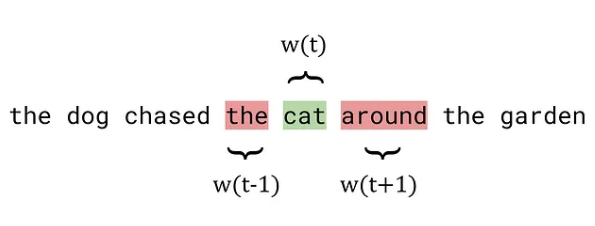

Para un tamaño de ventana de 2, se toman dos palabras antes y después de la palabra central (dando un total de cuatro palabras), y así sucesivamente. Si no es posible tomar ninguna palabra antes o después de la palabra central, entonces el modelo simplemente tomará lo que esté disponible. Por ejemplo, la primera "the" de la oración anterior no tiene palabras anteriores $w(t-1)$ o $w(t-2)$. En este caso, con un tamaño de ventana de 2, las palabras exteriores solo serán "dog" y "chased". Los tamaños de las ventanas varían según el caso de uso y se pueden ajustar para encontrar el valor más apropiado; sin embargo, los valores típicos oscilan entre 1 y 10.

##**Comparación de Skip-Gram y CBOW (Continuous Bag of Words):**
Ambos métodos utilizan una red neuronal con una única capa oculta para generar las incrustaciones de palabras. La diferencia radica en sus objetivos:

- **Skip-Gram:** Toma una palabra central y predice las palabras externas.

- **CBOW:** Toma algunas palabras externas y predice la palabra central.

Expliquemos como funciona el método de skip-gram. Los mismos principios aplican para CBOW.

La arquitectura de un modelo Word2Vec basado en skip-gram se muestra a continuación (MLP):

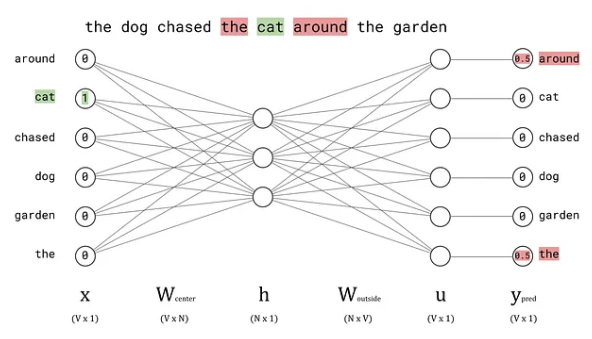

La entrada al modelo es un vector codificado por One-Hot, en donde se tendrá un 1 en la posición correspondiente a la palabra central y un 0 en el resto de las posiciones:

$\mathbf{X} \in \{0,1\}^{Vx1}$

Donde $V$ es esl tamaño del vocabulario del corpus de entrenamiento.

Ahora, la salida de la capa oculta se halla a través de la siguiente capa densa:

$h=\mathbf{W}^{T}_{center}\mathbf{X} \in \mathbb{R}^{Nx1}$

Donde $\mathbf{W}_{center} \in \mathbb{R}^{VxN}$ es la matrix de pesos que codificara la representación vectorial N-dimensional de cada una de las palabras y $N$ es la dimensión de cada uno de esos vectores. Dicha matrix se inicializa aleatoriamente siguiendo una distribución normal o uniforme y se irá ajustando a través de backpropagation, en cada época de entrenamiento.

Notemos que a la hora de entrenar nuestro modelo WordVec, se tiene en cuenta el contexto de cada uno de los tokens (es decir, las palabras que se tienen al lado izquieredo y derecho), pero una vez se entrena, la representación vectorial N-dimensional de estos tokens ya se vuelve estática sin importar su contexto (es decir, las palabras que lo rodean).


Ahora, la salida de la capa de salia es:

$u=\mathbf{W}^{T}_{outside}\mathbf{h} \in \mathbb{R}^{Vx1}$

Donde $\mathbf{W}_{outside} \in \mathbb{R}^{NxV}$ es la matrix de pesos de la capa de salida.

Posteriormente, se pasa el vector $u$ por una función de activación softmax para obtener las probabilidades que tiene cada palabra del vocabulario a ser externa a la palabra central.

$Y_{pred}=SOFTMAX(u) \in [0,1]^{Vx1}$

Es decir, que:

$Y_{true} \in [0,1]^{Vx1}$, donde se tomará el valor de 1 en las posiciones correspondientes a las palabras externas y 0 en el resto de las palabras.

La función de costo que se planeta para entrenar estos modelos Word2Vec es la [Negative Log Likelihood](https://medium.com/@bradneysmith/word-embeddings-with-word2vec-from-scratch-in-python-eb9326c6ab7c).

Veamos un ejemplo a cerca de como entrenar estos modelos Word2Vec desde cero, obteniendo embeddings de tres dimensiones:

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re


class word2vec:
    """ An implementation of the word2vec Skip-Gram algorithm.

    Attributes:
        embedding_dim (int): The number of dimensions in the output word
            embeddings.
        window_size (int): The number of outside words to consider either side
            of a center word.
        epochs (int): The number of epochs to use in training.
        learning_rate (float): The learning rate used for gradient descent to
            iteratively improve the weight matrices. Smaller values (~0.01) are
            generally preferred.
        embeddings (np.array[np.array]): The matrix of static word embeddings
            produced by the model.
        encoded_training_data (np.array[np.array]): A collection of center
            words and their corresponding outside words encoded as one-hot
            vectors.
        losses (list[int]): The loss for each epoch of the model's training.
            Can be used to plot the decrease in the loss over training.
        training_data (list[str]): A list of strings of raw text, which is
            converted to encoded_training_data and used to train the model.
        vec_to_word (dict): A dictionary which maps a string version of the
            one-hot vector to a word string.
        vocab (list): An alphabetised list of all the unique words in the
            training data.
        vocab_size (int): The number of unique words in the training data.
    """

    def __init__(self, embedding_dim, window_size, epochs, learning_rate):
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.epochs = epochs
        self.learning_rate = learning_rate

        self.embeddings = None
        self.encoded_training_data = None
        self.losses = []
        self.training_data = None
        self.vec_to_word = None
        self.vocab = None
        self.vocab_size = None


    def calculate_loss(self, outside_words, y_pred):
        """ Calculate the loss.

        Calculate the loss according to the negative log likelihood function.
        This requires taking the sum of the log P(w_{t+j}|w_t) values (log of
        the softmax outputs, y_pred). To do this, first combine all the one-hot
        encoded outside word vectors into a single vector called
        combined_outside_words. For example, if two outside words have vectors
        [0 1 0 0 0 0] and[0 0 0 0 1 0], the combined_outside_words vector will
        be [0 1 0 0 1 0]. Next multiply this new vector with the softmax
        outputs, y_pred, to obtain the softmax values for the outside words -
        store the result in a vector called components. The components vector
        will have some elements with a value of 0, and so these should be
        removed before taking the elementwise log of the vector. After removing
        and taking the log of the remaining elements, sum the log values to
        give the loss and return the value.

        Args:
            outside_words (np.array[np.arrays]): An array of one-hot encoded
                vectors for each outside word.
            y_pred (np.array): An array of softmax outputs from the network for
              a given center word.

        Returns:
            loss (float): The loss of the network for the input center word.

        """
        # Combine the one-hot outside word vectors into a single vector with 1s
        # for each outside word and 0s for all other words
        combined_outside_words = np.sum(outside_words, axis=0)

        # Multiply by y_pred element-wise to get the components of y_pred that
        # are inside the window
        components = np.multiply(combined_outside_words, y_pred)

        # Find the indexes of the non-zero values in the components vector and
        # remove them to
        # prevent taking log(0) in the next step
        non_zero_idx = np.where(components != 0)[0]
        non_zero_components = components[non_zero_idx]

        # Take the log of the non-zero values
        log_components = np.log(non_zero_components)

        # Sum the log of the
        loss = -np.sum(log_components)

        return loss


    def create_vec_to_word_map(self):
        """ Return a map to convert one-hot vectors back into words."""
        self.vec_to_word = {str(one_hot(word, self.vocab, self.vocab_size)): \
                            word for word in self.vocab}


    def create_vocabulary(self):
        """ Return a sorted list of words by tokenizing training data."""
        all_words = ' '.join(training_data).lower()
        all_words = all_words.replace('.', '')
        all_words = all_words.split(' ')
        self.vocab = list(set(all_words))
        self.vocab.sort()
        self.vocab_size = len(self.vocab)


    def encode_training_data(self):
        """ Encode the center and outside words as one-hot vectors."""

        self.encoded_training_data = []

        for sentence in training_data:

            # Tokenize the sentence
            tokens = re.sub(r'[^\w\s]', '', sentence).lower().split(' ')

            # Encode each center word and its surrounding context words
            for word_pos, word in enumerate(tokens):
                center_word = self.one_hot(word)

                outside_words = []
                for outside_pos in range(word_pos-self.window_size,
                                         word_pos+self.window_size+1):

                    if (outside_pos >= 0) and (outside_pos < len(tokens)) \
                    and (outside_pos != word_pos):

                        outside_words.append(self.one_hot(tokens[outside_pos]))

                self.encoded_training_data.append([center_word, outside_words])


    def one_hot(self, word):
        """ Return a one-hot encoded vector for a word.

        Args:
            word (str): A word from the training data.

        Returns:
            one_hot (np.array): A one-hot encoded vector representation of the
                input word.
        """
        one_hot = [0]*self.vocab_size
        pos = self.vocab.index(word)
        one_hot[pos] = 1
        one_hot = np.array(one_hot)
        return one_hot


    def softmax(self, u):
        """ Return the softmax values for a vector u.

        Args:
            u (np.array): A vector of raw network outputs (logits).

        Returns:
            values (np.array): A vector of softmax values for the input, u.
        """
        values = np.exp(u)/np.sum(np.exp(u))
        return values


    def train(self, training_data):
        """ Take in raw text and produce a matrix of word embeddings.

        From the raw text in training_data, create an alphabetised vocabulary
        of unique words and encode each center word and its corresponding
        outside words as one-hot vectors. Initialise the weights matrices
        W_center and W_outside that store the connections between the layers in
        the network. For each center word in the encoded training data,
        compute a forward, calculate the loss, and compute a backward pass.
        Print the loss for each epoch and repeat until every epoch has been
        completed. Store the final embeddings in the self.embeddings attribute.

        Args:
            training_data (list[str]): A list of strings of raw text, which is
                converted to encoded_training_data and used to train the model.

        Returns:
            None.
        """
        self.create_vocabulary()
        self.encode_training_data()

        # Initialise the connections between layers
        W_center = np.random.rand(self.vocab_size, EMBEDDING_DIM)
        W_outside = np.random.rand(EMBEDDING_DIM, self.vocab_size)

        for epoch_num in range(self.epochs):

            loss = 0

            for x, outside_words in self.encoded_training_data:

                # Forward pass
                h = np.dot(x, W_center)
                u = np.dot(h, W_outside)
                y_pred = self.softmax(u)

                # Calculate the loss
                loss += self.calculate_loss(outside_words, y_pred)

                # Backward pass
                e = np.sum([y_pred - ow for ow in outside_words], axis=0)
                grad_W_outside = np.outer(h, e)
                grad_W_center = np.outer(x, np.dot(W_outside, e))
                W_outside = W_outside - (self.learning_rate * grad_W_outside)
                W_center = W_center - (self.learning_rate * grad_W_center)

            self.losses.append(loss)
            print(f'Epoch: {epoch_num+1}    Loss: {loss}')

        self.embeddings = W_center


EMBEDDING_DIM = 3
WINDOW_SIZE = 2
EPOCHS = 1000
LEARNING_RATE = 0.01

# Create training data
training_data = ['The dog chased the cat around the garden.',
                 'The cat drank some water.',
                 'The dog ate some food.',
                 'The cat ate the mouse.']

# Instantiate the model
w2v = word2vec(embedding_dim = EMBEDDING_DIM,
               window_size = WINDOW_SIZE,
               epochs = EPOCHS,
               learning_rate = LEARNING_RATE)

# Train the model
w2v.train(training_data[:1000])

Epoch: 1    Loss: 157.99268966019704
Epoch: 2    Loss: 155.24760606304238
Epoch: 3    Loss: 152.9678717985007
Epoch: 4    Loss: 151.03014042910462
Epoch: 5    Loss: 149.35239922538588
Epoch: 6    Loss: 147.87764308860878
Epoch: 7    Loss: 146.5647156471537
Epoch: 8    Loss: 145.38288491858805
Epoch: 9    Loss: 144.30851111528042
Epoch: 10    Loss: 143.32294998918
Epoch: 11    Loss: 142.41121108752571
Epoch: 12    Loss: 141.56108520217862
Epoch: 13    Loss: 140.76256441151995
Epoch: 14    Loss: 140.00744337599784
Epoch: 15    Loss: 139.2890313645886
Epoch: 16    Loss: 138.60193056305184
Epoch: 17    Loss: 137.94185302579388
Epoch: 18    Loss: 137.30545966111578
Epoch: 19    Loss: 136.6902121603279
Epoch: 20    Loss: 136.094234140319
Epoch: 21    Loss: 135.5161815674869
Epoch: 22    Loss: 134.95512488013202
Epoch: 23    Loss: 134.41044606922372
Epoch: 24    Loss: 133.8817533807393
Epoch: 25    Loss: 133.36881461805893
Epoch: 26    Loss: 132.87150786149485
Epoch: 27    Loss: 132.389786478

Viusalizemos la representación vectorical 3-dimensional de las plabras presentes en el corpus con el cual entrenamos:

In [9]:
w2v.embeddings.shape

(12, 3)

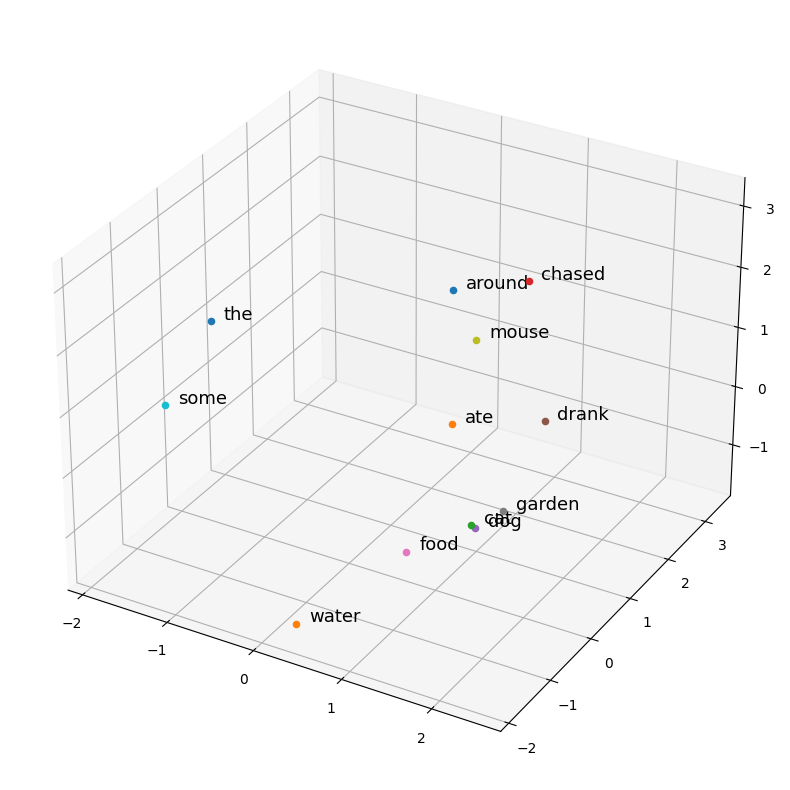

In [10]:
# Plot the word embeddings
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i, (x,y,z) in enumerate(w2v.embeddings):
    ax.scatter(x,y,z)
    ax.text(x+0.1, y+0.1, z, w2v.vocab[i], size=13)

Como se puede ver, efectivamente las palabras similares quedan cercanas entre si, mientras que las palabras diferentes semánticamente quedan distantes entre si.

Ahora, una desventaja de un modelo Word2Vec con respecto a un modelo LLM Pre-Entrenado para hallar representación contextual de los tokens de un texto, es que un modelo Word2Vec no podrá hallar la representación vectorial de una palabra que nunca vió en su proceso de entrenamiento, mientras que un modelo LLM-Pre-Entrenado para tal fin, sí lo podrá hacer (Ya que habitualmente construyen los Ids de sus palabras basados en el algoritmo de WordPiece, que precisamente esa es la principal ventaja que tiene).

Veamos como se comportó la función de costo en nuestro proceso de entrenamiento:

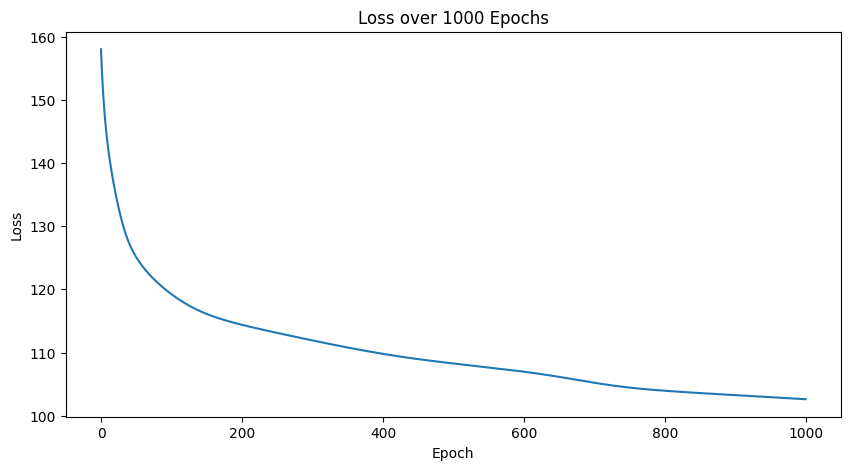

In [11]:
# Plot the loss with each epoch
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Loss over {EPOCHS} Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

y = w2v.losses
x = list(range(EPOCHS))

ax.plot(x, y)

Ahora, veamos como es esta representación vectorial estática de los tokens utilizando un modelo que ya fue previamente entrenado sobre un corpus de 100 billones de palabras y que me entrega representaciones vectoriales de 3oo dimensiones.

In [12]:
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

In [14]:
text="""In the heart of the city, where the bustle and frenetic pace of modern life dominated every corner, stood a building of
           Imposing appearance. Its tall glass towers reflected the sunlight, creating sparkles that were lost in the urban horizon.
           Inside, a labyrinth of corridors and stairs connected the countless offices where decisions were made that affected the
           destination of miles of people. It was the nerve center of the economy, where power and money were intertwined in an eternal dance.
           But behind the facade of success and prosperity, dark secrets were hidden. Corrupt brokers, dirty deals and excessive ambitions
           They dyed the corridors illuminated by artificial light with shadows. Here, the value of a life was measured in numbers on a screen, and loyalty
            It was a scarce commodity that was bought from the highest bidder.
            However, among the tangle of interests and hidden agendas, some were looking for a light of hope.
            Small gestures of kindness, acts of silent bravery, that impressed upon everyone that, even in the heart of darkness,
            He could still find the flame of humanity. And so, in that corner of steel and glass, the fight between good and evil,
            between greed and compassion, continued its eternal course, while the world turned endlessly in its ceaseless race towards the future."""

In [13]:
# Print the model description
model_dict = gensim.downloader.info()['models']['word2vec-google-news-300']

for key in ['num_records', 'base_dataset', 'description']:
    print(f'{key: <12}: {model_dict[key]}')

# Download in the model
google_cbow = api.load('word2vec-google-news-300') #Load the pre-trained word2vec model


num_records : 3000000
base_dataset: Google News (about 100 billion words)
description : Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [116]:
def get_tokens_of_the_text(texto):
    # Convertimos el texto a minúsculas para evitar problemas de orden alfabético
    texto = texto.lower()
    # Dividimos el texto en palabras usando el espacio como delimitador
    palabras = texto.split()
    # Ordenamos la lista de palabras
    palabras_ordenadas = sorted(palabras)
    return palabras_ordenadas

tokens = get_tokens_of_the_text(text.replace(".","").replace(",","")) #Get the tokens of the text

In [144]:
len(tokens)

194

In [165]:
tokens=list(set(tokens))

In [156]:
tokens.remove("and") #Words the WordVec model doesn´t know

In [166]:
embeddings=google_cbow[tokens] #Get the word embeddings of the tokens

In [167]:
embeddings.shape

(133, 300)

Ahora hagamos una reducción de dimensión con T-SNE y veamos como se ven estos word-emdeddings en un espacio bidimensional:

In [161]:
from sklearn.manifold import TSNE

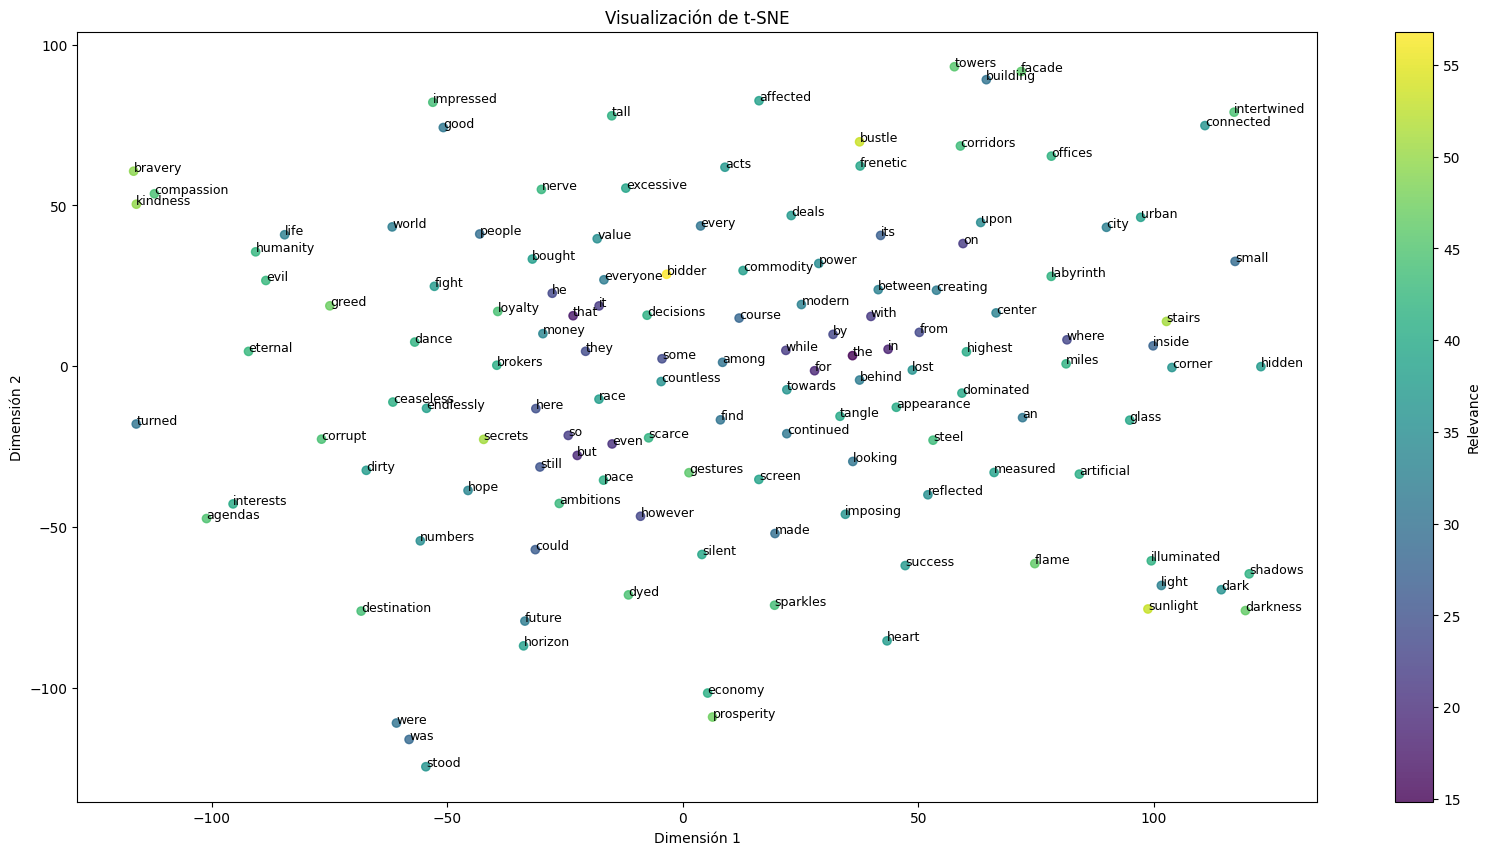

In [168]:
# Apply T-SNE to carry to two dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=4)
embedding_two_dimensions = tsne.fit_transform(embeddings)


dic_suma_tokens={}
for j,token in enumerate(embeddings):
  suma=np.sum(np.abs(token))
  dic_suma_tokens[tokens[j]]=suma
words_relevance = np.array([dic_suma_tokens[token] for token in tokens])

# Visualizar el resultado en un scatter plot
plt.figure(figsize=(20, 10))
plt.scatter(embedding_two_dimensions[:, 0], embedding_two_dimensions[:, 1], alpha=0.8,cmap="viridis",c=words_relevance)
plt.colorbar(label='Relevance')  # Etiqueta de la barra de color

# Enumerar cada punto
for k, (x, y) in enumerate(embedding_two_dimensions):
    plt.text(x, y, tokens[k], fontsize=9)

plt.title(f'Visualización de t-SNE')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

Como se puede ver, efectivamente las palabras más similares entre si (como por ejemplo economy y prosperity o were y was) quedan cercanas entre si.

Es decir, que a diferencia de un modelo LLM Pre-Entrenado para hallar representaciones contextuales de los tokens, con un modelo Word2Vec los grupos de palabras similares entre si sí se arman más claramente, lo cual no pasa con las representaciones contextuales de los tokens halladas con un LLM Pre-Entrenado, pues precisamente esas representaciones se ven muy influenciadas por el contexto (las palabras que tengan al lado).